In [3]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from src.environments import water_desalination_environment_v2
from torch.distributions import Categorical
%matplotlib inline 

In [4]:
plant = water_desalination_environment_v2.env()

In [5]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.Activation = F.leaky_relu
        self.affine1 = nn.Linear(6, 8)
        self.affine2 = nn.Linear(8, 8)
        self.affine3 = nn.Linear(8, 3)
        
    def forward(self, x):
        x = self.Activation(self.affine1(x))
        x = self.Activation(self.affine2(x))
        action_scores = (self.affine3(x))
        prob = F.softmax(action_scores, dim=1)
        return prob
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.Activation = F.leaky_relu
        self.fc1 = nn.Linear(6, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.Activation(x)
        x = self.fc2(x)
        return x

In [6]:
def rollout(env, actor, critic, BS = 8):
    log_probs = []
    rewards = []
    states = []
    values = []
    for _ in range(BS):
        done = False
        state = env.reset()
        rewards_one_game = []
        log_probs_one_game = []
        states_one_game = []
        values_one_game = []
        while not done:
            state = torch.from_numpy(state * np.array([4.159547242912022, 4, 100, 2, 1440, 22000]) ** -1).float().unsqueeze(0) # Normalization is included in the casting to tensor
            probs = actor(state)
            value = critic(state)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
            state, reward, done, _ = env.step(action.item())
            rewards_one_game.append(reward)
            log_probs_one_game.append(log_prob)
            states_one_game.append(state)
            values_one_game.append(value)
        rewards.append(rewards_one_game)
        log_probs.append(log_probs_one_game)
        values.append(values_one_game)
        states.append(states_one_game)
    return states, rewards, log_probs, values

# Plain Actor-Critic

In [7]:
torch.manual_seed(0)
actor = Actor()
actor_optim = optim.Adam(actor.parameters()) #, lr=1e-2
critic = Critic()
critic_optim = optim.Adam(critic.parameters(), lr = 1e-2) #, 1e-2

In [8]:
valueEstimate_training_AC = []
rewardHistory_training_AC = []
for it in tqdm(range(1000)):
  states, rewards, log_probs, values = rollout(plant, actor, critic)
  R = np.array([np.sum(episode_rewards) for episode_rewards in rewards])
  rewardHistory_training_AC.append(np.mean(R))
  logProbSum = torch.stack([torch.sum(torch.stack(episode_log_probs)) for episode_log_probs in log_probs])
  
  V = torch.tensor([vals[0] for vals in values], requires_grad = True)

  # actor_loss = -torch.mean(logProbSum*torch.tensor(R))
  actor_loss = -torch.mean(logProbSum*(torch.tensor(R)-V.detach()))
  actor_optim.zero_grad()
  actor_loss.backward()
  actor_optim.step()

  critic_loss = torch.mean((V-torch.tensor(R))**2)
  critic_optim.zero_grad()
  critic_loss.backward()
  critic_optim.step()

  valueEstimate_training_AC.append(torch.mean(V).item())

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/ts/6y1n3jld49lbmhkghmw7zksr0000gn/T/ipykernel_11266/1426897016.py:14: RuntimeWarning: invalid value encountered in reciprocal
  state = torch.from_numpy(state * np.array([4.159547242912022, 4, 100, 2, 1440, 22000]) ** -1).float().unsqueeze(0) # Normalization is included in the casting to tensor
100%|██████████| 1000/1000 [2:29:09<00:00,  8.95s/it] 


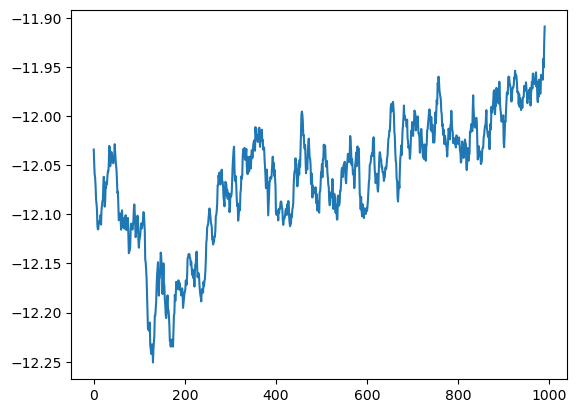

In [9]:
# Plot moving average of reward history with window size 10
def plot_moving_average(values, window=10):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    plt.plot(sma)
plot_moving_average(rewardHistory_training_AC)
#plt.plot(rewardHistory_training_AC)
#plt.plot(valueEstimate_training_AC,'r--')

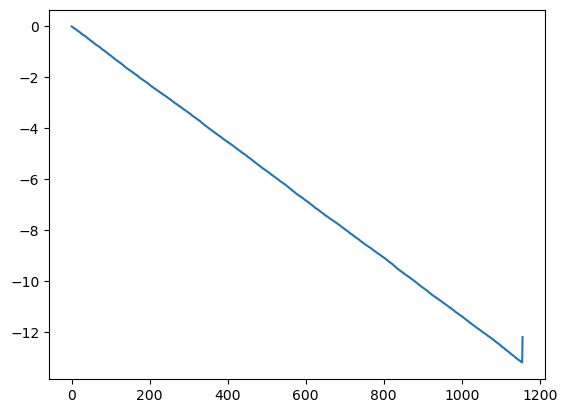

In [11]:
state = plant.reset()
done = False
rewardHistory = []
actionHistory = []
while not done:
    state = torch.from_numpy(state * np.array([4.159547242912022, 4, 100, 2, 1440, 22000]) ** -1).float().unsqueeze(0)
    probs = actor(state)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    state, reward, done, _ = plant.step(action.item())
    rewardHistory.append(reward)
    actionHistory.append(action.item())
# Cumulative reward
plt.plot(np.cumsum(rewardHistory))


In [13]:
actionHistory.count(2.0)

417

In [14]:
actionHistory.count(1.0)

423

In [15]:
actionHistory.count(0)

317

In [16]:
len(rewardHistory)

1157

# Actor-Critic with causality trick

In [60]:
torch.manual_seed(0)
actor_ct = Actor()
actor_optim_ct = optim.Adam(actor_ct.parameters()) #, lr=1e-2
critic_ct = Critic()
critic_optim_ct = optim.Adam(critic_ct.parameters(), lr = 1e-2) #, 1e-2

In [70]:
valueEstimate_training_AC_ct = []
rewardHistory_training_AC_ct = []
ANorm2=[]
CNorm2=[]
for it in tqdm(range(500)):
  states, rewards, log_probs, values = rollout(plant, actor_ct, critic_ct)
  R = np.array([np.sum(episode_rewards) for episode_rewards in rewards])
  rewardHistory_training_AC_ct.append(np.mean(R))

  # R = []
  # rewardSum = np.array(rewards)[0]*0
  # for r in reversed(rewards):
  #   rewardSum += r
  #   R.insert(0,rewardSum+0.0)

  # actor_loss = -torch.mean(logProbSum*torch.tensor(R))
  values_detached = [torch.stack(episode_values).squeeze().detach() for episode_values in values]
  actor_loss = -torch.mean(torch.stack([torch.sum(torch.stack(log_probs[i]).squeeze() * (R[i] - values_detached[i])) for i in range(len(log_probs))]))

  # actor_loss = -torch.mean(torch.stack([torch.sum(torch.stack(log_probs[i]).squeeze() * (R[i] - torch.stack(values[i]).squeeze().detach())) for i in range(len(log_probs))]))
  actor_optim_ct.zero_grad()
  actor_loss.backward()
  actor_optim_ct.step()
  # critic loss for different size of rollout episodes

  # critic_loss = torch.mean((torch.stack([torch.stack(episode_values).squeeze() for episode_values in values]).squeeze() - torch.tensor(R))**2)
  # Make list of tensors a tensor from values
  values = [torch.stack(episode_values).squeeze() for episode_values in values]

  critic_loss = torch.sum(torch.stack([torch.sum((R[i] - values[i]) ** 2) for i in range(len(log_probs))])) / sum([len(episode) for episode in rewards])
  critic_optim_ct.zero_grad()
  critic_loss.backward()
  critic_optim_ct.step()

  nor = 0.0
  for w in actor_ct.parameters():
    nor+= torch.norm(w.grad)**2
  ANorm2.append(nor)

  nor = 0.0
  for w in critic_ct.parameters():
    nor+= torch.norm(w.grad)**2
  CNorm2.append(nor)
  
  V = torch.tensor([vals[0] for vals in values])
  valueEstimate_training_AC_ct.append(torch.mean(V).item())

100%|██████████| 500/500 [56:08<00:00,  6.74s/it]


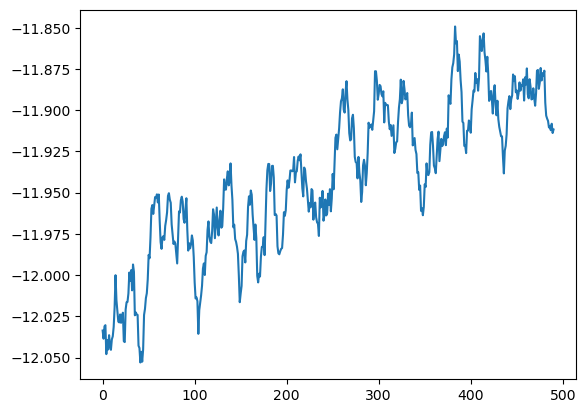

In [73]:
def plot_moving_average(values, window=10):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    plt.plot(sma)
plot_moving_average(rewardHistory_training_AC_ct)

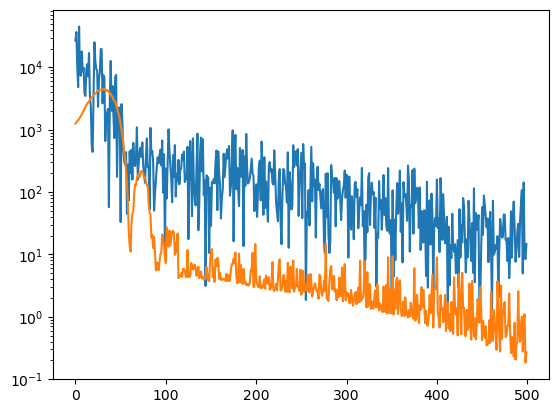

In [71]:
plt.semilogy(ANorm2)
plt.semilogy(CNorm2)

# Random policy

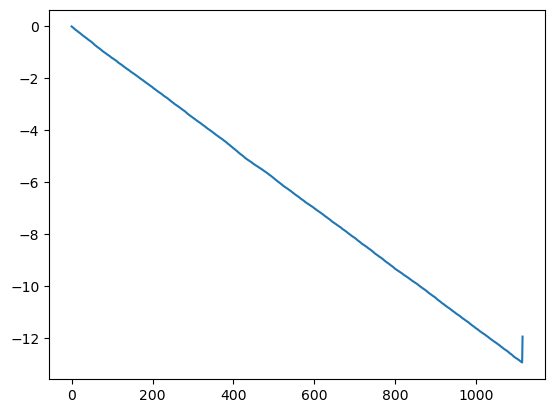

In [45]:
state = plant.reset()
done = False
rewardHistory = []
actionHistory = []
while not done:
    state = torch.from_numpy(state * np.array([4.162170130901638, 4, 100, 2, 1440, 22000]) ** -1).float().unsqueeze(0)
    action = np.random.randint(0,3)
    state, reward, done, _ = plant.step(action)
    rewardHistory.append(reward)
    actionHistory.append(action)
# Cumulative reward
plt.plot(np.cumsum(rewardHistory))

In [42]:
np.random.randint(0,3)

0

In [46]:
actionHistory.count(2.0)

367

In [47]:
actionHistory.count(1)

391

In [48]:
actionHistory.count(0)

358